In [1]:
# import libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split

In [2]:
initialDf = pd.read_csv("steam.csv")
initialDf.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [3]:
for var in initialDf.columns:
    if len(initialDf[var]) != len(initialDf[var].dropna()):
        print(var)
print('Done')
#Check to see if there are any na's

Done


In [4]:
df = pd.DataFrame()
df["Name"] = initialDf["name"].apply(lambda x: str(x))
df["ReleaseYear"] = initialDf["release_date"].apply(lambda x: int(x[0:4]))
df["ReleaseMonth"] = initialDf["release_date"].apply(lambda x: int(x[5:7]))
df["English"] = initialDf["english"].apply(lambda x: int(x))
df["Developer"] = initialDf["developer"].apply(lambda x: str(x))
df["Publisher"] = initialDf["publisher"].apply(lambda x: str(x))
df["Windows"] = initialDf["platforms"].apply(lambda x: bool("windows" in x))
df["Mac"] = initialDf["platforms"].apply(lambda x: bool("mac" in x))
df["Linux"] = initialDf["platforms"].apply(lambda x: bool("linux" in x))
df["RequiredAge"] = initialDf["required_age"].apply(lambda x: int(x))
df["Categories"] = initialDf["categories"].apply(lambda x: str(x))
df["Genre"] = initialDf["genres"].apply(lambda x: str(x))
df["Price"] = initialDf["price"].apply(lambda x: float(x))


df["PositiveRatings"] = initialDf["positive_ratings"].apply(lambda x: int(x))
df["NegativeRatings"] = initialDf["negative_ratings"].apply(lambda x: int(x))
df["MedianPlaytime"] = initialDf["median_playtime"].apply(lambda x: str(x))
df["AveragePlaytime"] = initialDf["average_playtime"].apply(lambda x: str(x))
df["LowerOwners"] = initialDf["owners"].apply(lambda x: int(x[:x.find("-")]))
df["UpperOwners"] = initialDf["owners"].apply(lambda x: int(x[x.find("-")+1:]))

In [5]:
df["NegativeRatings"].replace({0: 1}, inplace=True)


In [6]:
df.describe()

,ReleaseYear,ReleaseMonth,English,RequiredAge,Price,PositiveRatings,NegativeRatings,LowerOwners,UpperOwners
count,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,2.707500e+04,27075.000000,2.707500e+04,2.707500e+04
mean,2016.498098,6.555457,0.981127,0.354903,6.078193,1.000559e+03,211.134478,8.012669e+04,1.880543e+05
std,2.156990,3.459959,0.136081,2.406044,7.874922,1.898872e+04,4284.933257,8.708977e+05,1.786801e+06
min,1997.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000e+00,2.000000e+04
25%,2016.000000,3.000000,1.000000,0.000000,1.690000,6.000000e+00,2.000000,0.000000e+00,2.000000e+04
50%,2017.000000,7.000000,1.000000,0.000000,3.990000,2.400000e+01,9.000000,0.000000e+00,2.000000e+04
75%,2018.000000,10.000000,1.000000,0.000000,7.190000,1.260000e+02,42.000000,2.000000e+04,5.000000e+04
max,2019.000000,12.000000,1.000000,18.000000,421.990000,2.644404e+06,487076.000000,1.000000e+08,2.000000e+08


In [7]:
df['Pos_over_Neg'] =  (df['PositiveRatings'] / df['NegativeRatings'] ) * 100

In [8]:
df.describe()
df['Ratio_over_std'] = np.where(df['Pos_over_Neg']>=844.356909, 1, 0)

In [9]:
df.head()


,Name,ReleaseYear,ReleaseMonth,English,Developer,Publisher,Windows,Mac,Linux,RequiredAge,...,Genre,Price,PositiveRatings,NegativeRatings,MedianPlaytime,AveragePlaytime,LowerOwners,UpperOwners,Pos_over_Neg,Ratio_over_std
0,Counter-Strike,2000,11,1,Valve,Valve,True,True,True,0,...,Action,7.19,124534,3339,317,17612,10000000,20000000,3729.679545,1
1,Team Fortress Classic,1999,4,1,Valve,Valve,True,True,True,0,...,Action,3.99,3318,633,62,277,5000000,10000000,524.170616,0
2,Day of Defeat,2003,5,1,Valve,Valve,True,True,True,0,...,Action,3.99,3416,398,34,187,5000000,10000000,858.291457,1
3,Deathmatch Classic,2001,6,1,Valve,Valve,True,True,True,0,...,Action,3.99,1273,267,184,258,5000000,10000000,476.779026,0
4,Half-Life: Opposing Force,1999,11,1,Gearbox Software,Valve,True,True,True,0,...,Action,3.99,5250,288,415,624,5000000,10000000,1822.916667,1


In [10]:
def pos_neg(var):
    y = df['Pos_over_Neg']
    x = df[var]
    figure = plt.figure(figsize = (25,7))
    plt.scatter(x, y, marker='o');
    plt.ylabel('(Positive/Negative) Rating')
    plt.xlabel(var)

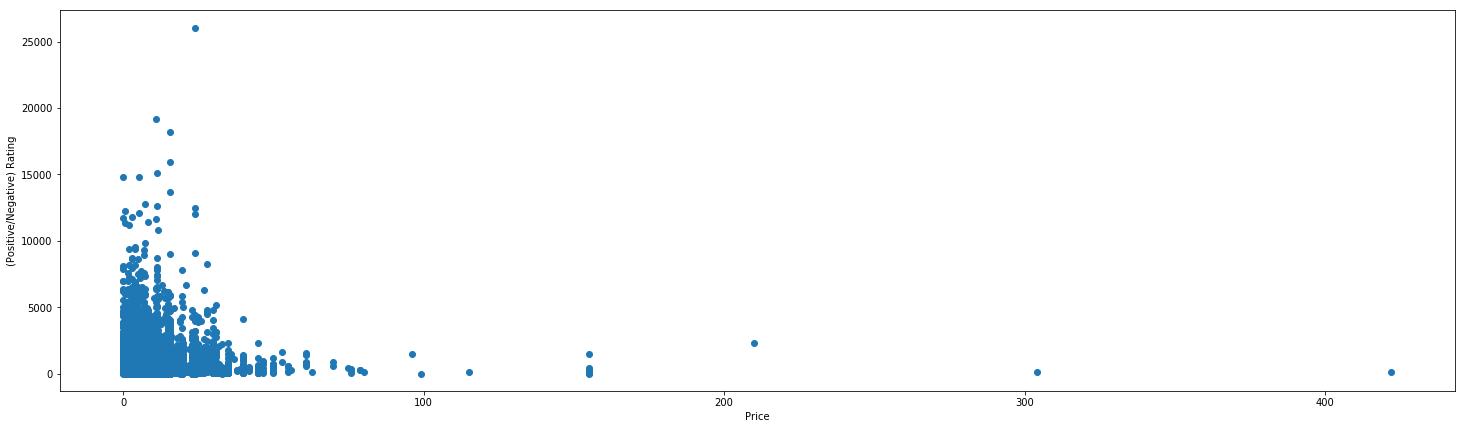

In [11]:
pos_neg("Price")


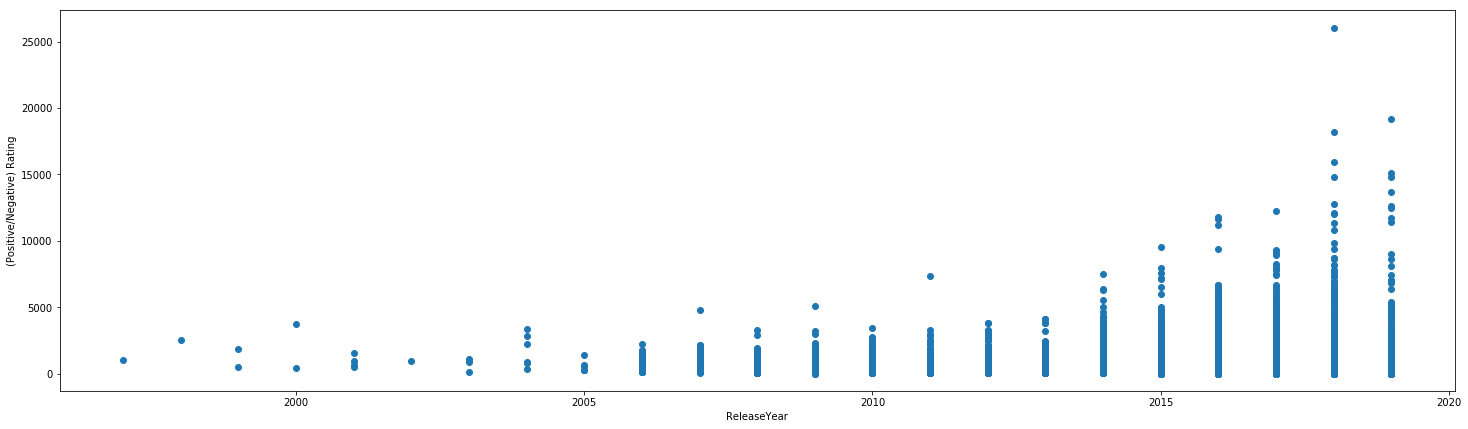

In [12]:
pos_neg("ReleaseYear")

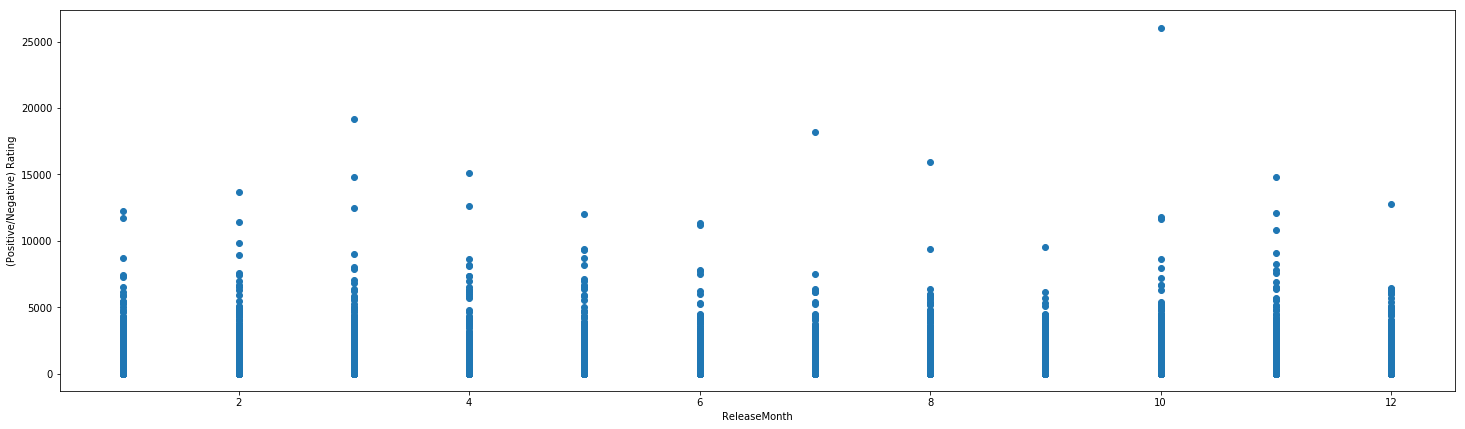

In [13]:
pos_neg("ReleaseMonth")

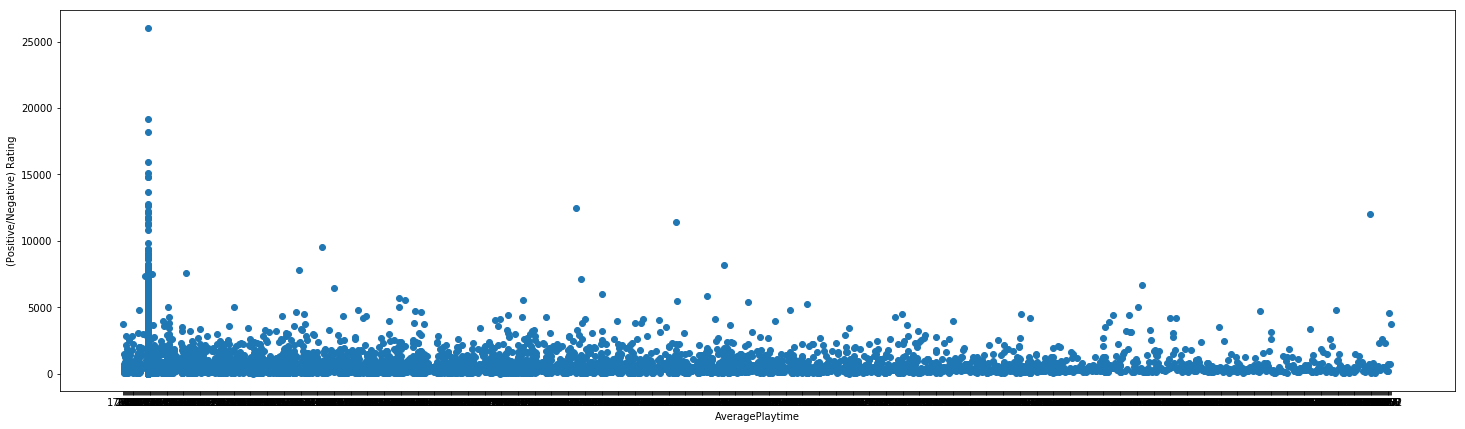

In [14]:
pos_neg("AveragePlaytime")

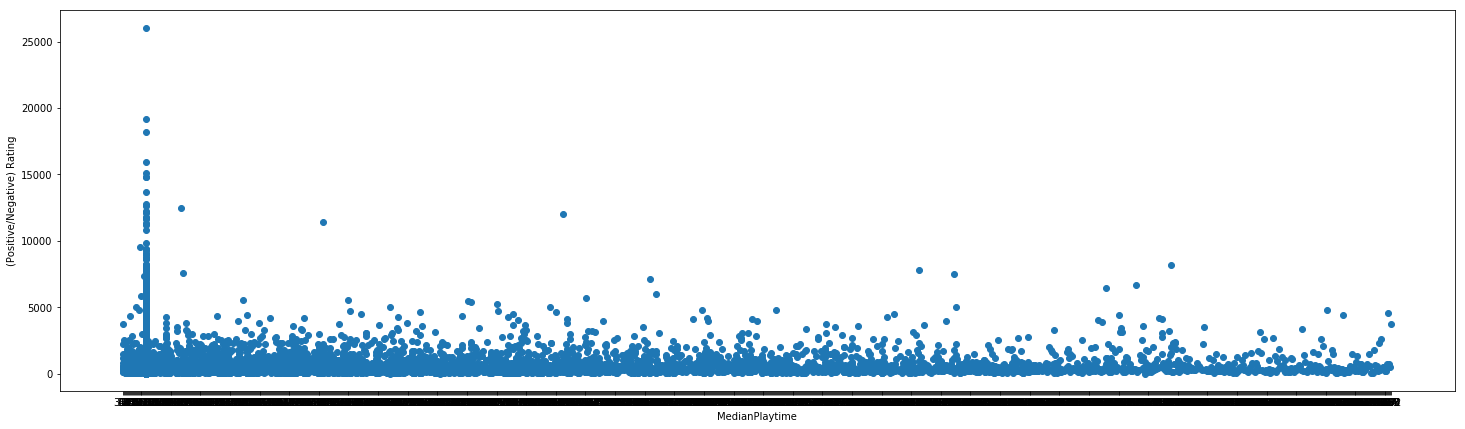

In [15]:
pos_neg("MedianPlaytime")

Text(0, 0.5, '(Positive/Negative) Rating')

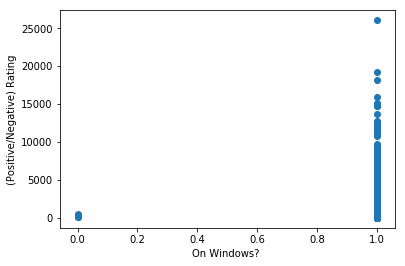

In [16]:
plt.scatter(df.Windows, df["Pos_over_Neg"], label='Widnows')
plt.xlabel('On Windows? ')
plt.ylabel('(Positive/Negative) Rating')

Text(0, 0.5, '(Positive/Negative) Rating')

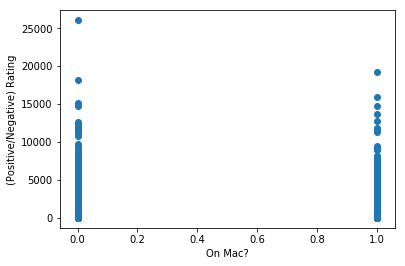

In [17]:
plt.scatter(df.Mac, df["Pos_over_Neg"], label='Mac')
plt.xlabel('On Mac?')
plt.ylabel('(Positive/Negative) Rating')

Text(0, 0.5, '(Positive/Negative) Rating')

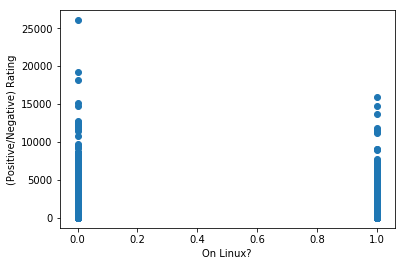

In [18]:
plt.scatter(df.Linux, df["Pos_over_Neg"], label='Linux')
plt.xlabel('On Linux?')
plt.ylabel('(Positive/Negative) Rating')

In [19]:

df=df.drop(columns=['Name', 'Publisher','Developer','Categories','Genre','PositiveRatings','NegativeRatings','Pos_over_Neg'])


In [20]:
features = df.columns.drop(["Ratio_over_std"])

target = 'Ratio_over_std'

In [21]:
df.head()

,ReleaseYear,ReleaseMonth,English,Windows,Mac,Linux,RequiredAge,Price,MedianPlaytime,AveragePlaytime,LowerOwners,UpperOwners,Ratio_over_std
0,2000,11,1,True,True,True,0,7.19,317,17612,10000000,20000000,1
1,1999,4,1,True,True,True,0,3.99,62,277,5000000,10000000,0
2,2003,5,1,True,True,True,0,3.99,34,187,5000000,10000000,1
3,2001,6,1,True,True,True,0,3.99,184,258,5000000,10000000,0
4,1999,11,1,True,True,True,0,3.99,415,624,5000000,10000000,1


In [22]:
for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].apply(lambda x: int(1 if x else 0))
print(df)

       ReleaseYear  ReleaseMonth  English  Windows  Mac  Linux  RequiredAge  \
0             2000            11        1        1    1      1            0   
1             1999             4        1        1    1      1            0   
2             2003             5        1        1    1      1            0   
3             2001             6        1        1    1      1            0   
4             1999            11        1        1    1      1            0   
5             2000            11        1        1    1      1            0   
6             1998            11        1        1    1      1            0   
7             2004             3        1        1    1      1            0   
8             2001             6        1        1    1      1            0   
9             2004            11        1        1    1      1            0   
10            2004            11        1        1    1      1            0   
11            2004             6        1        1  

In [23]:
df.describe()

,ReleaseYear,ReleaseMonth,English,Windows,Mac,Linux,RequiredAge,Price,LowerOwners,UpperOwners,Ratio_over_std
count,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,2.707500e+04,2.707500e+04,27075.000000
mean,2016.498098,6.555457,0.981127,0.999815,0.297913,0.193352,0.354903,6.078193,8.012669e+04,1.880543e+05,0.167165
std,2.156990,3.459959,0.136081,0.013588,0.457350,0.394934,2.406044,7.874922,8.708977e+05,1.786801e+06,0.373130
min,1997.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000e+04,0.000000
25%,2016.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.690000,0.000000e+00,2.000000e+04,0.000000
50%,2017.000000,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.990000,0.000000e+00,2.000000e+04,0.000000
75%,2018.000000,10.000000,1.000000,1.000000,1.000000,0.000000,0.000000,7.190000,2.000000e+04,5.000000e+04,0.000000
max,2019.000000,12.000000,1.000000,1.000000,1.000000,1.000000,18.000000,421.990000,1.000000e+08,2.000000e+08,1.000000


In [24]:
df.reset_index(inplace = True) 

In [25]:
lenTrain, lenVal = 25000, 1000
train, test = train_test_split(df, test_size=len(df)-lenTrain-lenVal)
train, val = train_test_split(train, test_size=lenVal)

In [26]:
X_train, X_val, X_test = train[features], val[features], test[features]
y_train, y_val, y_test = train[target], val[target], test[target]



'''
X_train=tf.keras.utils.normalize(X_train, axis=1)
X_val=tf.keras.utils.normalize(X_val, axis=1)
X_test=tf.keras.utils.normalize(X_test, axis=1)

y_train=tf.keras.utils.normalize(y_train, axis=1)
y_val=tf.keras.utils.normalize(y_val, axis=1)
y_test=tf.keras.utils.normalize(y_test, axis=1)

'''


'\nX_train=tf.keras.utils.normalize(X_train, axis=1)\nX_val=tf.keras.utils.normalize(X_val, axis=1)\nX_test=tf.keras.utils.normalize(X_test, axis=1)\n\ny_train=tf.keras.utils.normalize(y_train, axis=1)\ny_val=tf.keras.utils.normalize(y_val, axis=1)\ny_test=tf.keras.utils.normalize(y_test, axis=1)\n\n'

In [27]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(max_iter=1000)

# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)

D:\Program Files\Anaconda\envs\tf1.0\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [29]:
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.83070


In [ ]:
hu1 = 9
hu2 = 4
afunc = tf.nn.relu

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(hu1, activation=afunc))
#model.add(tf.keras.layers.Dense(hu2, activation=afunc))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

In [ ]:
optim = 'adam'
model.compile(optimizer=optim,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=1000)

In [ ]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(val_loss)
print(val_acc)

In [ ]:
val_loss, val_acc = model.evaluate(X_test, y_test)
print(val_loss)
print(val_acc)